In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# Load the datasets
train_emoticon_df = pd.read_csv('/content/drive/MyDrive/datasets/train/train_emoticon.csv')
train_text_seq_df = pd.read_csv('/content/drive/MyDrive/datasets/train/train_text_seq.csv')

train_feat = np.load("/content/drive/MyDrive/datasets/train/train_feature.npz", allow_pickle=True)
train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']


# Load the validation datasets
valid_emoticon_df = pd.read_csv("/content/drive/MyDrive/datasets/valid/valid_emoticon.csv")
valid_text_seq_df = pd.read_csv("/content/drive/MyDrive/datasets/valid/valid_text_seq.csv")
valid_feat = np.load("/content/drive/MyDrive/datasets/valid/valid_feature.npz", allow_pickle=True)

# Define the averaging feature vectorizer for the deep feature set
def feature_vectorizer(features):
    """
    Convert the 13x786 matrix into a suitable representation by averaging the 13 embeddings.

    Args:
        features (numpy array): The 13x786 matrix.

    Returns:
        numpy array: Averaged vectorized feature representation (1x786).
    """
    # Naive approach: averaging the 13 embeddings
    return features.flatten()
# Apply the feature vectorizer to each row in train_feat_X
vectorized_features = np.array([feature_vectorizer(f) for f in train_feat_X])
vectorized_valid_features = np.array([feature_vectorizer(f) for f in valid_feat['features']])

# Now we can integrate these vectorized deep features with the emoticon and text features

# Convert the emoticons and text sequences to numerical representations
emoticon_vectorizer = CountVectorizer(analyzer='char')  # Vectorize emoticons as characters
text_vectorizer = CountVectorizer(analyzer='char')  # Vectorize text as characters

X_emoticon = emoticon_vectorizer.fit_transform(train_emoticon_df['input_emoticon'])
X_text = text_vectorizer.fit_transform(train_text_seq_df['input_str'])

# Transform validation data
X_emoticon_valid = emoticon_vectorizer.transform(valid_emoticon_df['input_emoticon'])  # Use transform, not fit_transform
X_text_valid = text_vectorizer.transform(valid_text_seq_df['input_str'])  # Use transform, not fit_transform


# Concatenate the emoticon, text, and vectorized deep features
X_combined_text = hstack([X_emoticon, X_text])
X_combined_valid = hstack([X_emoticon_valid, X_text_valid, vectorized_valid_features])

# Concatenate the averaged deep features with the combined emoticon and text features
X_combined_final = hstack([X_combined_text, vectorized_features])
X_combined_valid = hstack([X_emoticon_valid, X_text_valid, vectorized_valid_features])

# Labels for training (using emoticon_df labels for now)
y_train_combined = train_emoticon_df['label'].values
y_val_combined = valid_emoticon_df['label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = X_combined_final, X_combined_valid, y_train_combined, y_val_combined



# Check the shape of the final combined dataset
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (7080, 10208)
Validation set size: (489, 10208)


**First without the dimension reduction, here the trainable parameters are exceeding 10k**

In [ ]:
import pandas as pd

# Convert the sparse matrix to a dense format and then to a DataFrame
X_combined_train_df = pd.DataFrame(X_combined_final.toarray())

# Display the first 5 rows of the DataFrame
X_combined_train_df.head()


,0,1,2,3,4,5,6,7,8,9,...,10198,10199,10200,10201,10202,10203,10204,10205,10206,10207
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.126582,0.055177,-0.118184,-0.131268,-0.248308,-0.030563,-0.210591,-0.028888,0.016804,0.082894
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099424,0.050894,-0.103064,-0.059938,-0.253473,-0.177246,-0.040373,0.140488,-0.020949,-0.003448
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.140411,0.079247,-0.047782,-0.149243,-0.252450,-0.023745,0.010205,0.043697,-0.008699,0.000463
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.100640,0.101118,-0.117015,-0.145422,-0.231792,-0.048320,-0.089497,-0.059478,0.082911,-0.024833
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099424,0.050894,-0.103064,-0.059938,-0.253473,-0.177246,-0.040373,0.140488,-0.020949,-0.003448


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Validation
y_pred = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")

Validation Accuracy: 0.9856850715746421


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**To reduce the number of parameters, we use PCA, which reduces the number of trainable parameters to 500**

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the number of features to a number that results in fewer than 10,000 parameters
# Assuming that we reduce the feature size to something smaller (e.g., 500 components)
pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_combined_final.toarray())  # Convert sparse matrix to dense array for PCA
X_val_pca = pca.transform(X_combined_valid.toarray())  # Apply the same transformation to the validation set

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_pca, y_train)

# Validation
y_pred = model.predict(X_val_pca)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")


Validation Accuracy: 0.983640081799591


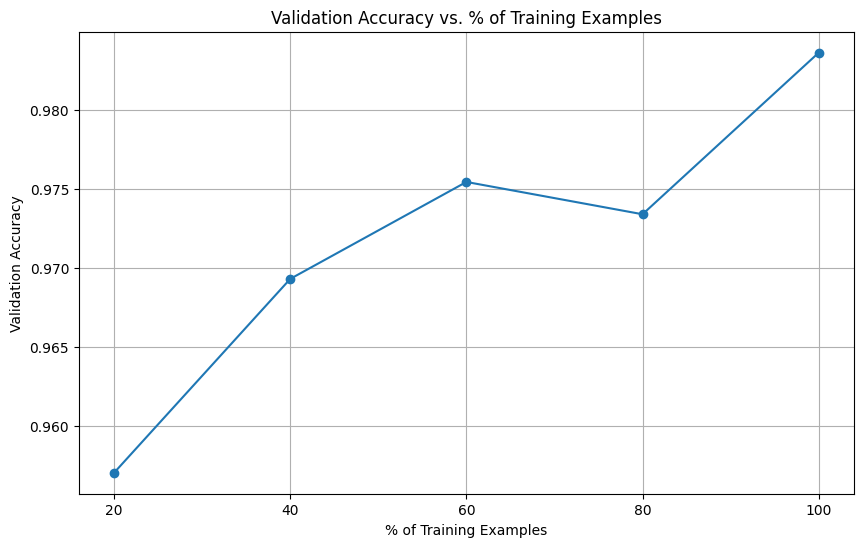

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Percentages of training data to use
train_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

# List to store validation accuracies
validation_accuracies = []

# Iterate through the specified percentages
for percentage in train_percentages:
    # Determine the number of training examples to use
    num_examples = int(percentage * X_train_pca.shape[0])

    # Select the first `num_examples` from the training set
    X_train_subset = X_train_pca[:num_examples]
    y_train_subset = y_train[:num_examples]

    # Train the Logistic Regression model on the subset
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_subset, y_train_subset)

    # Validate on the full validation set
    y_pred = model.predict(X_val_pca)
    accuracy = accuracy_score(y_val, y_pred)

    # Store the accuracy
    validation_accuracies.append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.array(train_percentages) * 100, validation_accuracies, marker='o')
plt.title('Validation Accuracy vs. % of Training Examples')
plt.xlabel('% of Training Examples')
plt.ylabel('Validation Accuracy')
plt.xticks(np.array(train_percentages) * 100)  # Set x-ticks to be percentage values
plt.grid(True)
plt.show()


**We'll take 60 percent of data for training, after that it starts to over fit. We have first horizontally stacked the test data of all the three files and and then applied PCA for dimension reduction. And trained the model on 60 percent data and produced the predictions.**

In [ ]:
# Load the datasets
test_emoticon_df = pd.read_csv('/content/drive/MyDrive/datasets/test/test_emoticon.csv')
test_text_seq_df = pd.read_csv('/content/drive/MyDrive/datasets/test/test_text_seq.csv')

test_feat = np.load("/content/drive/MyDrive/datasets/test/test_feature.npz", allow_pickle=True)
test_feat_X = test_feat['features']

vectorized_features_test = np.array([feature_vectorizer(f) for f in test_feat_X])
X_emoticon_test = emoticon_vectorizer.fit_transform(test_emoticon_df['input_emoticon'])
X_text_test = text_vectorizer.fit_transform(test_text_seq_df['input_str'])

X_combined_final_test = hstack([X_emoticon_test, X_text_test, vectorized_features_test])
X_test_pca = pca.fit_transform(X_combined_final_test.toarray())  # Convert sparse matrix to dense array for PCA


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Percentages of training data to use
train_percentages = 0.6
# Determine the number of training examples to use
num_examples = int(train_percentages * X_train.shape[0])

# Select the first `num_examples` from the training set
X_train_subset = X_train_pca[:num_examples]
y_train_subset = y_train[:num_examples]

# Train the Logistic Regression model on the subset
model = LogisticRegression(max_iter=1000)
model.fit(X_train_subset, y_train_subset)

# Validate on the full validation set
y_pred_combined = model.predict(X_test_pca)


np.savetxt('pred_combined.txt', y_pred_combined, fmt='%d')